<a href="https://colab.research.google.com/github/AmedeeRoy/BirdDL/blob/main/Dive_Prediction_1D_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Seabird Diving Behaviour with GPS data

Supervized Learning with Deep Networks


## Data Formatting

In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython
import datetime
import random
import pickle

In [ ]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
# connect to database
conn = sqlite3.connect('/content/drive/My Drive/data/seabirdbank.db')

In [ ]:
request = "SELECT DISTINCT lon, lat FROM fieldwork WHERE place='Pescadores'"
colony = pd.read_sql_query(request, conn)
colony = colony.values
colony

array([[-77.264, -11.773]])

In [ ]:
request = "SELECT \
            trip.id as trip, gps.datetime, gps.lon, gps.lat\
            FROM gps \
            INNER JOIN trip ON gps.trip = trip.id \
            INNER JOIN bird ON trip.bird = bird.id \
            WHERE trip.file_gps IS NOT NULL \
            AND trip.file_tdr IS NOT NULL \
            AND (bird.fieldwork = 'P1108' OR bird.fieldwork = 'P1111' \
                OR bird.fieldwork = 'P1112' OR bird.fieldwork = 'P1113') \
            AND bird.species = 'SV'"

# substr(bird.fieldwork,1,1) = 'P'

gps = pd.read_sql_query(request, conn)
gps

,trip,datetime,lon,lat
0,P1108_4_SV_T1,2008-11-25 13:00:35,-77.264128,-11.773317
1,P1108_4_SV_T1,2008-11-25 13:00:36,-77.264118,-11.773235
2,P1108_4_SV_T1,2008-11-25 13:00:37,-77.264098,-11.773152
3,P1108_4_SV_T1,2008-11-25 13:00:38,-77.264113,-11.773060
4,P1108_4_SV_T1,2008-11-25 13:00:39,-77.264142,-11.772955
...,...,...,...,...
839803,P1113_50_SV_T2,2013-11-25 05:23:26,-77.264832,-11.773701
839804,P1113_50_SV_T2,2013-11-25 05:23:27,-77.264862,-11.773664
839805,P1113_50_SV_T2,2013-11-25 05:23:28,-77.264900,-11.773705
839806,P1113_50_SV_T2,2013-11-25 05:23:29,-77.264931,-11.773739


In [ ]:
# check duplicated datetime in GPS trip
idx = gps.index[gps.loc[:, 'trip':'datetime'].duplicated(keep=False)]
idx_drop = [idx[i] for i in range(0, len(idx), 2)]
gps = gps.drop(idx_drop)

In [ ]:
gps[gps.loc[:, 'trip':'datetime'].duplicated(keep=False)]

,trip,datetime,lon,lat


In [ ]:
request = "SELECT \
            trip.id as trip, tdr.datetime, tdr.pressure \
            FROM tdr \
            INNER JOIN trip ON tdr.trip = trip.id \
            INNER JOIN bird ON trip.bird = bird.id \
            WHERE trip.file_gps IS NOT NULL \
            AND trip.file_tdr IS NOT NULL \
            AND (bird.fieldwork = 'P1108' OR bird.fieldwork = 'P1111' \
                OR bird.fieldwork = 'P1112' OR bird.fieldwork = 'P1113') \
            AND bird.species = 'SV'"

# WHERE substr(bird.fieldwork,1,1) = 'P' 

tdr = pd.read_sql_query(request, conn)
tdr

,trip,datetime,pressure
0,P1108_4_SV_T1,2008-11-25 13:00:35,-0.35
1,P1108_4_SV_T1,2008-11-25 13:00:36,-0.38
2,P1108_4_SV_T1,2008-11-25 13:00:37,-0.35
3,P1108_4_SV_T1,2008-11-25 13:00:38,-0.29
4,P1108_4_SV_T1,2008-11-25 13:00:39,-0.29
...,...,...,...
1086337,P1113_50_SV_T2,2013-11-25 05:23:26,-0.94
1086338,P1113_50_SV_T2,2013-11-25 05:23:27,-0.94
1086339,P1113_50_SV_T2,2013-11-25 05:23:28,-0.94
1086340,P1113_50_SV_T2,2013-11-25 05:23:29,-0.94


In [ ]:
tdr['datetime'] = pd.to_datetime(tdr['datetime'], format='%Y-%m-%d %H:%M:%S')
gps['datetime'] = pd.to_datetime(gps['datetime'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
df = pd.merge(tdr, gps, on=['trip', 'datetime'], how='left')
df

,trip,datetime,pressure,lon,lat
0,P1108_4_SV_T1,2008-11-25 13:00:35,-0.35,-77.264128,-11.773317
1,P1108_4_SV_T1,2008-11-25 13:00:36,-0.38,-77.264118,-11.773235
2,P1108_4_SV_T1,2008-11-25 13:00:37,-0.35,-77.264098,-11.773152
3,P1108_4_SV_T1,2008-11-25 13:00:38,-0.29,-77.264113,-11.773060
4,P1108_4_SV_T1,2008-11-25 13:00:39,-0.29,-77.264142,-11.772955
...,...,...,...,...,...
1086337,P1113_50_SV_T2,2013-11-25 05:23:26,-0.94,-77.264832,-11.773701
1086338,P1113_50_SV_T2,2013-11-25 05:23:27,-0.94,-77.264862,-11.773664
1086339,P1113_50_SV_T2,2013-11-25 05:23:28,-0.94,-77.264900,-11.773705
1086340,P1113_50_SV_T2,2013-11-25 05:23:29,-0.94,-77.264931,-11.773739


In [ ]:
# check NaN and fill with interpolations
[i for i, x in enumerate(df['lon'].isna()) if x]


df['lon'] = df['lon'].interpolate(method='polynomial', order=2)
df['lat'] = df['lat'].interpolate(method='polynomial', order=2)

In [ ]:
len(df.trip.unique())

185

In [ ]:
# threshold = 1
# path_folder = "./trajectory/"

# for t in df.trip.unique():
    
#     path_file = path_folder + t
#     df_trip = df[df.trip == t]
    
#     bias = np.median(df_trip.pressure.values)
  
#     plt.figure(figsize=(9, 3))

#     plt.subplot(1, 2, 1)
#     plt.plot(df_trip.datetime.values, df_trip.pressure.values)
#     plt.plot(df_trip.datetime.values, [threshold+bias for i in range(len(df_trip))], color = 'orange')

#     plt.subplot(1, 2, 2)
#     plt.plot(df_trip.lon.values, df_trip.lat.values)
#     plt.scatter(df_trip.lon.values[df_trip.pressure-bias > threshold], \
#                 df_trip.lat.values[df_trip.pressure-bias > threshold], c = 'orange')
    
#     plt.savefig(path_file)
#     plt.close()

In [ ]:
bad_trip = ['P1111_9_SV_T1', 'P1111_13_SV_T6', 'P1111_41_SV_T2', 'P1111_46_SV_T5', 'P1111_52_SV_T1',
            'P1112_4_SV_T2', 'P1112_26_SV_T5', 'P1112_36_SV_T1', 'P1112_36_SV_T2', 'P1113_41_SV_T3',
           'P1113_50_SV_T2']

no_loop = ['P1112_26_SV_T1', 'P1112_26_SV_T2', 'P1112_26_SV_T3', 'P1112_26_SV_T4']

In [ ]:
### remove bad data
idx = df.index[[(t in bad_trip or t in no_loop) for t in df.trip]]
df = df.drop(idx)

In [ ]:
len(df.trip.unique())

170

## Trip Statistics

In [ ]:
df_trip = df[df.trip == 'P1108_4_SV_T1']
df_trip

,trip,datetime,pressure,lon,lat
0,P1108_4_SV_T1,2008-11-25 13:00:35,-0.35,-77.264128,-11.773317
1,P1108_4_SV_T1,2008-11-25 13:00:36,-0.38,-77.264118,-11.773235
2,P1108_4_SV_T1,2008-11-25 13:00:37,-0.35,-77.264098,-11.773152
3,P1108_4_SV_T1,2008-11-25 13:00:38,-0.29,-77.264113,-11.773060
4,P1108_4_SV_T1,2008-11-25 13:00:39,-0.29,-77.264142,-11.772955
...,...,...,...,...,...
6622,P1108_4_SV_T1,2008-11-25 14:50:57,-0.29,-77.264097,-11.773710
6623,P1108_4_SV_T1,2008-11-25 14:50:58,-0.29,-77.264223,-11.773817
6624,P1108_4_SV_T1,2008-11-25 14:50:59,-0.26,-77.264307,-11.773860
6625,P1108_4_SV_T1,2008-11-25 14:51:00,-0.22,-77.264363,-11.773875


In [ ]:
def dist_ortho(lon1, lat1, lon2, lat2):
    R = 6377726
    pi = np.pi
    a = np.sin((lat1 - lat2)/2*pi/180)**2
    b = np.cos(lat1*pi/180)*np.cos(lat2*pi/180)
    c = np.sin((lon1- lon2)/2* pi/180)**2
    
    dist = R * 2* np.arcsin( np.sqrt(a + b*c))
    return dist

def cap(lon1, lat1, lon2, lat2):
    pi = np.pi
    
    # to radians
    lat1 = lat1*pi/180
    lat2 = lat2*pi/180
    lon1 = lon1*pi/180
    lon2 = lon2*pi/180
    
    delta_lon = lon2-lon1
    
    a = np.cos(lat1) * np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(delta_lon)
    b = np.sin(delta_lon) * np.cos(lat2)
    
    cap = np.arctan2(b , a)
    cap = cap%(2*pi)
    
    return cap*180/pi

class Trip:
    def __init__(self, df):
        
        self.df = df.set_index(np.arange(len(df)))  
        
        # matrix of distance
        self.dist_matrix = np.zeros((len(self.df), len(self.df)))
    
    ### GENERAL STATISTICS ### -----------------------------------------------
    
    def get_duration(self):
        return max(self.df.datetime) - min(self.df.datetime)
    
    def get_distance(self):
        return sum(self.get_step())/1e3
    
    ### STEP-ANGLE PAIRS ### -----------------------------------------------
    
    def get_step(self):
        n = len(self.df)
        step = dist_ortho( self.df.lon.values[0:(n-1)], self.df.lat.values[0:(n-1)], self.df.lon.values[1:n], self.df.lat.values[1:n])
        return step
    
    def add_step(self):
        self.df['step'] = np.append(np.nan, self.get_step())
        
    def get_cap(self):
        n = len(self.df)
        c = cap( self.df.lon.values[0:(n-1)], self.df.lat.values[0:(n-1)], self.df.lon.values[1:n], self.df.lat.values[1:n])
        return c
    
    def add_cap(self):
        self.df['cap'] = np.append(np.nan, self.get_cap())
 
    def get_direction(self):
        direction = [d%360 - 360 if d%360 > 180 else d%360 for d in np.diff(self.get_cap())]
        return np.array(direction)
    
    def add_direction(self):
        a = np.empty(2)
        a.fill(np.nan)
        self.df['direction'] = np.append(a, self.get_direction())
      
    def plot(self):
        
        threshold = 1
        bias = np.median(df_trip.pressure.values)
        
        plt.figure(figsize=(15, 3))

        plt.subplot(1, 3, 1)
        plt.plot(self.df.datetime.values, self.df.pressure.values)
        plt.plot(self.df.datetime.values, [threshold+bias for i in range(len(self.df))], color = 'orange')

        plt.subplot(1, 3, 2)
        plt.plot(self.df.lon.values, self.df.lat.values)
        plt.scatter(self.df.lon.values[self.df.pressure-bias > threshold], \
                    self.df.lat.values[self.df.pressure-bias > threshold], c = 'orange')
        
        plt.subplot(1, 3, 3)
        plt.scatter(self.df.direction, self.df.step, alpha = 0.3)
        plt.scatter(self.df.direction.values[self.df.pressure-bias > threshold],
                    self.df.step.values[self.df.pressure-bias > threshold], c = 'orange')
        
    
    ### AREA RESTRICTED RESEARCH ### -----------------------------------------------
    
    def compute_dist_matrix(self, verbose=True):
        for i in range(len(self.df)):
            lon1 = self.df.lon[[i for j in range(len(self.df))]]
            lat1 = self.df.lat[[i for j in range(len(self.df))]]
            lon2 = self.df.lon[[j for j in range(len(self.df))]]
            lat2 = self.df.lat[[j for j in range(len(self.df))]]

            self.dist_matrix[i, :] = dist_ortho(lon1.values, lat1.values, lon2.values, lat2.values)
            
            if verbose:
                IPython.display.clear_output(wait=True)
                print('Distance [{}/{}]'.format(i, len(self.df)))
                
    
    def residence_time(self, radius):
        residence_matrix = self.dist_matrix < radius
        residence = [sum(residence_matrix[:,i]) for i in range(len(self.df))]
        
        return residence
    
    def first_time_passage(self, radius):
        first_passage = np.zeros(len(t.df))
        residence_matrix = self.dist_matrix < radius
        
        for i in range(len(self.df)):

            idx = np.where(residence_matrix[:,i])[0]
            delta = np.diff(idx)
            
            # get index start
            i_start = i
            while i_start in idx:
                i_start -=1
            
            # get index end
            i_end = i
            while i_end in idx:
                i_end +=1
                
            # get number of point
            first_passage[i] = i_end-i_start+1
            
        return first_passage
    ### -----------------------------------------------

In [ ]:
t = Trip(df_trip)
t.add_step()
t.add_direction()

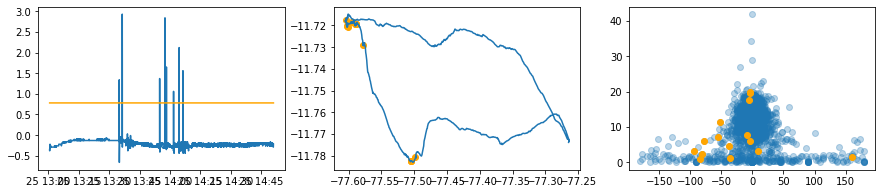

In [ ]:
t.plot()

In [ ]:
t.get_duration()

Timedelta('0 days 01:50:26')

In [ ]:
t.get_distance()

88.1484595608965

## Area Restricted Research

In [ ]:
%%time
t.compute_dist_matrix()

Distance [6626/6627]
CPU times: user 2min 3s, sys: 6.76 s, total: 2min 10s
Wall time: 2min 12s


In [ ]:
radius=500
residence = t.residence_time(radius)
first_passage = t.first_time_passage(radius)

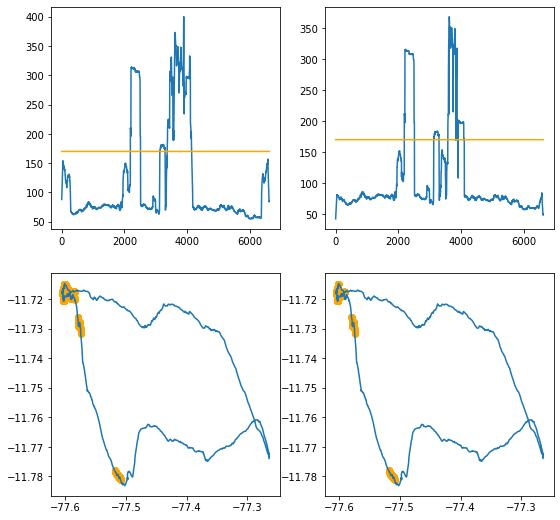

In [ ]:
tt = 170

plt.figure(figsize=(9, 9))

plt.subplot(2, 2, 1)
plt.plot(residence)
plt.plot(tt*np.ones(len(residence)), c = 'orange')

plt.subplot(2, 2, 2)
plt.plot(first_passage)
plt.plot(tt*np.ones(len(residence)), c = 'orange')

plt.subplot(2, 2, 3)
plt.plot(t.df.lon.values, t.df.lat.values)
plt.scatter(t.df.lon.values[np.array(residence)>tt], \
            t.df.lat.values[np.array(residence)>tt], c = 'orange')

plt.subplot(2, 2, 4)
plt.plot(t.df.lon.values, t.df.lat.values)
plt.scatter(t.df.lon.values[np.array(first_passage)>tt], \
            t.df.lat.values[np.array(first_passage)>tt], c = 'orange')

Area Restricted Approach seems to be ok, but it can not distinguish resting from foraging..

## Dive Prediction

In [ ]:
# standardized trajectories
df['lon_std'] = (df['lon'] - np.mean(df['lon']))/np.std(df['lon'])
df['lat_std'] = (df['lat'] - np.mean(df['lat']))/np.std(df['lat'])
df

,trip,datetime,pressure,lon,lat,lon_std,lat_std
0,P1108_4_SV_T1,2008-11-25 13:00:35,-0.35,-77.264128,-11.773317,0.562664,0.267015
1,P1108_4_SV_T1,2008-11-25 13:00:36,-0.38,-77.264118,-11.773235,0.562767,0.267824
2,P1108_4_SV_T1,2008-11-25 13:00:37,-0.35,-77.264098,-11.773152,0.562974,0.268642
3,P1108_4_SV_T1,2008-11-25 13:00:38,-0.29,-77.264113,-11.773060,0.562819,0.269549
4,P1108_4_SV_T1,2008-11-25 13:00:39,-0.29,-77.264142,-11.772955,0.562519,0.270584
...,...,...,...,...,...,...,...
1035988,P1113_50_SV_T1,2013-11-24 13:09:17,-1.01,-77.264229,-11.773601,0.561618,0.264216
1035989,P1113_50_SV_T1,2013-11-24 13:09:18,-1.07,-77.264221,-11.773701,0.561701,0.263230
1035990,P1113_50_SV_T1,2013-11-24 13:09:19,-1.07,-77.264191,-11.773771,0.562012,0.262540
1035991,P1113_50_SV_T1,2013-11-24 13:09:20,-1.01,-77.264168,-11.773826,0.562250,0.261998


In [ ]:
%%time

trajs = []
radius = 500
n = 1
for trip in df.trip.unique():
    df_trip = df[df.trip == trip]
    
#     t = Trip(df_trip)
#     t.compute_dist_matrix(verbose=False)
#     first_passage = t.first_time_passage(radius)
#     df_trip['first_time_passage'] = first_passage
    
    trajs.append(df_trip)
    
    IPython.display.clear_output(wait=True)
    print('Trip [{}/{}]'.format(n, len(df.trip.unique())))
    n+=1

Trip [170/170]
CPU times: user 19.1 s, sys: 261 ms, total: 19.4 s
Wall time: 19.7 s


In [ ]:
trajs[0]

,trip,datetime,pressure,lon,lat,lon_std,lat_std
0,P1108_4_SV_T1,2008-11-25 13:00:35,-0.35,-77.264128,-11.773317,0.562664,0.267015
1,P1108_4_SV_T1,2008-11-25 13:00:36,-0.38,-77.264118,-11.773235,0.562767,0.267824
2,P1108_4_SV_T1,2008-11-25 13:00:37,-0.35,-77.264098,-11.773152,0.562974,0.268642
3,P1108_4_SV_T1,2008-11-25 13:00:38,-0.29,-77.264113,-11.773060,0.562819,0.269549
4,P1108_4_SV_T1,2008-11-25 13:00:39,-0.29,-77.264142,-11.772955,0.562519,0.270584
...,...,...,...,...,...,...,...
6622,P1108_4_SV_T1,2008-11-25 14:50:57,-0.29,-77.264097,-11.773710,0.562985,0.263141
6623,P1108_4_SV_T1,2008-11-25 14:50:58,-0.29,-77.264223,-11.773817,0.561680,0.262087
6624,P1108_4_SV_T1,2008-11-25 14:50:59,-0.26,-77.264307,-11.773860,0.560811,0.261663
6625,P1108_4_SV_T1,2008-11-25 14:51:00,-0.22,-77.264363,-11.773875,0.560231,0.261515


In [ ]:
epochs = 100

extracted_trajs = []
n = 0
for dt in trajs:
    n += 1
    
    threshold = 1
    bias = np.median(dt.pressure.values)
        
    for i in range(len(dt)-epochs-1):
        tt = dt[i:(i+epochs)]
        
        extracted_trajs.append((tt.loc[:,'lon_std':'lat_std'].values, tt.pressure.values-bias ))
    
    IPython.display.clear_output(wait=True)
    print('Trip [{}/{}]'.format(n, len(df.trip.unique())))
            
random.shuffle(extracted_trajs)

Trip [170/170]


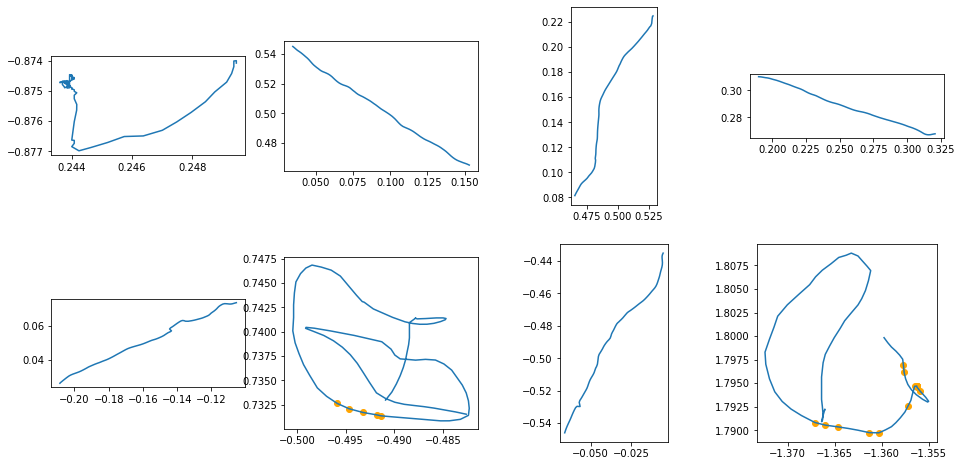

In [ ]:
plt.figure(figsize=(16, 8))

n = 0
for i in np.random.randint(0, high=len(extracted_trajs), size=8):
    n += 1
    
    pos = extracted_trajs[i][0]
    press = extracted_trajs[i][1]
    
    plt.subplot(2, 4, n)
    plt.plot(pos[:,0], pos[:,1])
    
    #selecting the current axis
    ax = plt.gca()
    ax.set_aspect(1)
    
    plt.scatter(pos[press>1,0], pos[press>1,1], c = 'orange')
    

In [ ]:
## define labels
extracted_trajs_labels = [(x, 1*(np.sum(y>1) >0)) for (x,y) in extracted_trajs]
extracted_trajs_labels[0]

(array([[0.98523514, 0.01577407],
        [0.98523514, 0.01577407],
        [0.98523514, 0.01577407],
        [0.98523514, 0.01577407],
        [0.98523514, 0.01577407],
        [0.98523514, 0.01577407],
        [0.98523514, 0.01577407],
        [0.98523514, 0.01577407],
        [0.98523514, 0.01577407],
        [0.98523514, 0.01577407],
        [0.98523514, 0.01577407],
        [0.98523514, 0.01577407],
        [0.98523514, 0.01577407],
        [0.98523514, 0.01577407],
        [0.98523514, 0.01577407],
        [0.98523514, 0.01577407],
        [0.98523514, 0.01577407],
        [0.98523514, 0.01577407],
        [0.98523514, 0.01577407],
        [0.98523514, 0.01577407],
        [0.98523514, 0.01577407],
        [0.98523514, 0.01577407],
        [0.98523514, 0.01577407],
        [0.98523514, 0.01577407],
        [0.98523514, 0.01577407],
        [0.98523514, 0.01577407],
        [0.98523514, 0.01577407],
        [0.98523514, 0.01577407],
        [0.98523514, 0.01577407],
        [0.985

In [ ]:
# split dataset in train and test
nb_test = round(len(extracted_trajs_labels)*0.2)

test_trajs = extracted_trajs_labels[0:nb_test]
train_trajs = extracted_trajs_labels[nb_test:len(extracted_trajs)]

In [ ]:
# re-balanced dataset
n = sum([ y for (x,y) in train_trajs])

idx_ones = np.where([ y>0 for (x,y) in train_trajs])[0]
idx_zeros = np.where([ y==0 for (x,y) in train_trajs])[0]
idx_zeros = np.random.choice(idx_zeros, n, replace = False)

train_trajs_balanced = [train_trajs[i] for i in idx_ones] + [train_trajs[i] for i in idx_zeros] 
random.shuffle(train_trajs_balanced)

In [ ]:
fileObj = open('/content/drive/My Drive/data/train_dives.obj', 'wb')
pickle.dump(train_trajs,fileObj)
fileObj.close()

fileObj = open('/content/drive/My Drive/data/test_dives.obj', 'wb')
pickle.dump(test_trajs,fileObj)
fileObj.close()